In [1]:
from trips.testProblems import *
from pylops import Identity, LinearOperator
from trips.utils import operator_qr, operator_svd, is_identity
from trips.parameter_selection.gcv import *
# from trips.parameter_selection.discrepancy_principle import *
import scipy.linalg as la
import scipy.optimize as op
import numpy as np
# from trips.solvers.Tikhonov import *
# from trips.solvers.Hybrid_LSQR import *

In [2]:
D1D = Deblurring1D()
N = 64
n = N
A = D1D.forward_Op_matrix_1D(3, N)
# A = np.vstack((A, np.random.rand(3,N)))
x_true = D1D.gen_xtrue(N, test = 'piecewise')
b_true = A@x_true
(b, delta) = D1D.add_noise(b_true, 'Gaussian', 0.05)
# plt.plot(x_true)
# D1D.plot_data(b)

In [3]:
deltavar1 = la.norm(b.reshape((-1,1)) - (A@x_true).reshape((-1,1)))
deltavar2 = la.norm(b.reshape((-1,1)) - np.matmul(A,x_true))
# deltavar = la.norm(b.reshape((-1,1)) - (A@x_true))
print(deltavar1)
print(deltavar2)
print(np.matmul(A,x_true).shape)
deltavar = deltavar1

0.06737815009758148
11.087829981625474
(64,)


In [4]:
import numpy as np
from trips.decompositions import golub_kahan, arnoldi
from trips.parameter_selection.gcv import generalized_crossvalidation
# from trips.parameter_selection.discrepancy_principle import discrepancy_principle
from trips.utils import smoothed_holder_weights
from collections.abc import Iterable
def Tikhonov(A, b, L, x_true, regparam = 'gcv', **kwargs):
    if regparam in ['gcv', 'GCV', 'Gcv']:
        lambdah = generalized_crossvalidation(A, b, L) # find ideal lambda by crossvalidation ###
        xTikh = np.linalg.solve(A.T@A + lambdah*L.T@L, A.T@b)
    elif regparam in ['DP', 'dp', 'Dp', 'Discrepancy Principle', 'Discrepancy principle', 'discrepancy principle']:
        lambdah = discrepancy_principle(A, b, L, **kwargs) # find ideal lambdas by discrepancy principle
        # print(lambdah)
        xTikh = np.linalg.solve(A.T@A + lambdah*L.T@L, A.T@b)
    else:
        lambdah = regparam
        xTikh = np.linalg.solve(A.T@A + lambdah*L.T@L, A.T@b)
    return xTikh, lambdah  

In [5]:
import numpy as np 
import scipy.linalg as la

from trips.utils import operator_qr, operator_svd, is_identity
import warnings

def discrepancy_principle_new(A, b, L, delta = None, eta = 1.01, **kwargs):

    if not ( isinstance(delta, float) or isinstance(delta, int)):

        # raise TypeError('You must provide a value for the noise level delta.')
        raise Exception("""A value for the noise level delta was not provided and the discrepancy principle cannot be applied. 
                    Please supply a value of delta based on the estimated noise level of the problem, or choose the regularization parameter according to gcv.""")

    if is_identity(L):
        Anew = A
        bnew = b
    else: ### MORE CASES TO BE CONSIDERED
        UL, SL, VL = la.svd(L)
        if L.shape[0] >= L.shape[1] and SL[-1] != 0:
            Anew = A@(VL.T@np.diag((SL)**(-1)))
            bnew = b
        elif SL[-1] == 0:
            zeroind = np.where(SL == 0)
            W = VL[:,zeroind]
            AW = A@W
            Q_AW, R_AW = linalg.qr(AW, mode='reduced')
            Q_LT, R_LT = linalg.qr(L.T, mode='reduced')
            LAwpinv = np.eye(L.shape[0]) - (W@np.linalg.inv(R_AW)@Q_AW.T@A)@Q_LT@np.linalg.inv(R_LT.T)
            Anew = A@LAwpinv
            xnull = W@np.linalg.inv(R_AW)@Q_AW.T@b
            bnew = b - A@xnull
    
    U, S, V = la.svd(Anew)
    singular_values = S**2
    singular_values = np.append(singular_values, 0)
    singular_values.shape = (singular_values.shape[0], 1)
    bhat = U.T @ bnew
    beta = 1e-8

    iterations = 0

    while (iterations < 30) or ((iterations <= 100) and (np.abs(alpha) < 10**(-16))):
        zbeta = (((singular_values*beta + 1)**(-1))*bhat.reshape((-1,1))).reshape((-1,1))
        f = la.norm(zbeta)**2 - (eta*delta)**2
        wbeta = (((singular_values*beta + 1)**(-1))*zbeta).reshape((-1,1))
        f_prime = 2/beta*zbeta.T@(wbeta - zbeta)

        beta_new = beta - f/f_prime

        if abs(beta_new - beta) < 10**(-12)* beta:
            break

        beta = beta_new
        alpha = 1/beta_new

        iterations += 1


    return alpha#{'x':alpha}

In [6]:
import numpy as np 
from scipy.optimize import newton, minimize
import scipy.optimize as op
import scipy.linalg as la

from trips.utils import operator_qr, operator_svd, is_identity
# from .gcv import gcv_numerator
import warnings

def discrepancy_principle_basic(A, b, L, delta = None, eta = 1.01, **kwargs):

    if not ( isinstance(delta, float) or isinstance(delta, int)):

        # raise TypeError('You must provide a value for the noise level delta.')
        raise Warning("""A value for the noise level delta was not provided. A default value of 0.01 has been used. 
                    Please supply a value of delta based on the estimated noise level of the problem.""")

        delta = 0.01
    
    tikh_sol = lambda reg_param: np.linalg.lstsq(np.vstack((A, np.sqrt(reg_param)*L)), np.vstack((b.reshape((-1,1)), np.zeros((L.shape[0],1)))))[0]
    discr_func_zero = lambda reg_param: np.linalg.norm(np.matmul(A,tikh_sol(reg_param)).reshape((-1,1)) - b.reshape((-1,1))) - (eta*delta)
    alpha = op.fsolve(discr_func_zero, 1e-10)[0]

    return alpha#{'x':alpha}

In [7]:
import numpy as np 
from scipy.optimize import newton, minimize
import scipy.optimize as op
import scipy.linalg as la

from trips.utils import operator_qr, operator_svd, is_identity
# from .gcv import gcv_numerator
import warnings

def discrepancy_principle(A, b, L, delta = None, eta = 1.01, **kwargs):

    if not ( isinstance(delta, float) or isinstance(delta, int)):

        # raise TypeError('You must provide a value for the noise level delta.')
        raise Warning("""A value for the noise level delta was not provided. A default value of 0.01 has been used. 
                    Please supply a value of delta based on the estimated noise level of the problem.""")

        delta = 0.01
    valid = True ## Just to be able to call the new DP that Silvia coded
    if is_identity(L) and valid == True:
        # print("zero finder")
        # U, S, V = la.svd(A, full_matrices=False)
        U, S, V = la.svd(A)
        # print(U.shape)
        # print(S.shape)
        singular_values = S**2
        singular_values = np.append(singular_values, 0)
        singular_values.shape = (singular_values.shape[0], 1)
        # print(singular_values.shape)
        bhat = U.T @ b
        # beta = 1.0
        beta = 1e-4

        alpha = 0.01

        iterations = 0

        while (iterations < 30) or ((iterations <= 100) and (np.abs(alpha) < 10**(-16))):
            print(iterations)
            # print(iterations)

            f = ((singular_values*beta + 1)**(-2)).T @ bhat - (eta*delta)**2

            f_prime = -2*  ((singular_values*beta + 1)**(-3) * singular_values).T @ bhat
            # print(((singular_values*beta + 1)**(-2)).shape)
            # print(bhat.shape)
            # print(singular_values.shape)
            # print(bhat.shape)
            # zbeta = (((singular_values*beta + 1)**(-1))*bhat.reshape((-1,1))).reshape((-1,1))
            # # print(zbeta.shape)
            # f = la.norm(zbeta)**2 - (eta*delta)**2
            # wbeta = (((singular_values*beta + 1)**(-1))*zbeta).reshape((-1,1))
            # # print(wbeta.shape)
            # f_prime = 2/beta*zbeta.T@(wbeta - zbeta)

            tikh_sol = lambda reg_param: np.linalg.lstsq(np.vstack((A, (1/np.sqrt(reg_param))*L)), np.vstack((b.reshape((-1,1)), np.zeros((L.shape[0],1)))))[0]
            discr_func_zero = lambda reg_param: (np.linalg.norm(np.matmul(A,tikh_sol(reg_param)).reshape((-1,1)) - (b.reshape((-1,1))))**2 - (eta*delta)**2)

            print(f)
            # print((np.matmul(A,tikh_sol(beta)).reshape((-1,1))).shape)
            print(discr_func_zero(beta))
            print(f_prime)

            beta_new = beta - f/f_prime

            # print(beta_new.shape)


            # if abs(beta_new - beta) < 10**(-7)* beta:
            if abs(beta_new - beta) < 10**(-12)* beta:
                # print('exit')
                break

            beta = beta_new

            alpha = 1/beta_new
            # print(alpha)

            iterations += 1
    else:
        tikh_sol = lambda reg_param: np.linalg.lstsq(np.vstack((A, np.sqrt(reg_param)*L)), np.vstack((b.reshape((-1,1)), np.zeros((L.shape[0],1)))))[0]
        discr_func_zero = lambda reg_param: np.linalg.norm(np.matmul(A,tikh_sol(reg_param)).reshape((-1,1)) - b.reshape((-1,1))) - (eta*delta)
        alpha = op.fsolve(discr_func_zero, 1e-10)[0]

    return alpha#{'x':alpha}

In [8]:
L = np.eye(12)
alpha = discrepancy_principle(B12, bhat, L, delta = deltavar, eta = 1.01)

NameError: name 'B12' is not defined

In [9]:
from trips.decompositions import golub_kahan_update
import numpy as np
from scipy import linalg as la
from trips.parameter_selection.gcv import *
# from trips.parameter_selection.discrepancy_principle import *
from pylops import Identity
from trips.solvers import Tikhonov

def hybrid_lsqr(A, b, n_iter, regparam = 'gcv', **kwargs): # what's the naming convention here?

    delta = kwargs['delta'] if ('delta' in kwargs) else None

    eta = kwargs['eta'] if ('eta' in kwargs) else 1.01

    if regparam == 'dp' and delta == None:
        raise Exception("""A value for the noise level delta was not provided and the discrepancy principle cannot be applied. 
                    Please supply a value of delta based on the estimated noise level of the problem, or choose the regularization parameter according to gcv.""")
    
    n = A.shape[1]
    beta = np.linalg.norm(b)
    U = b.reshape((-1,1))/beta
    B = np.empty(1)
    V = np.empty((n,1))
    RegParam = np.zeros(n_iter,)
    Rnrm = np.zeros(n_iter,)

    for ii in range(n_iter):
        # print(ii)
        (U, B, V) = golub_kahan_update(A, U, B, V)
        bhat = np.zeros(ii+2,); bhat[0] = beta ###
        L = Identity(B.shape[1], B.shape[1])
        y = la.lstsq(B,bhat)[0]
        nrmr = np.linalg.norm(bhat - B@y)
        Rnrm[ii] = nrmr
        if ii == 0:
            lambdah = 0
        else:
            if regparam == 'gcv':
                #lambdah = generalized_crossvalidation(B, bhat, L, **kwargs)['x'].item()
                lambdah = generalized_crossvalidation(B, bhat, L, **kwargs)
            elif regparam == 'dp':
                print(ii)
                # print(eta)
                # print(delta)
                # print(nrmr)
                if nrmr <= eta*delta:
                    lambdah = discrepancy_principle(B, bhat, L, **kwargs)#['x'].item()
                    # lambdah = 0
                else:
                    lambdah = 0
            else:
                lambdah = regparam
            RegParam[ii] = lambdah
            print(lambdah)
            L = L.todense() if isinstance(L, LinearOperator) else L
            y = la.lstsq(np.matmul(B.T,B) + lambdah*np.matmul(L.T,L), np.matmul(B.T,bhat))[0] ## SG: potentially needs L.T*L; also why lstsq? May just need a solver for linear system; also: you may need np.matmul; also: these are not the normal eqs (you need B'*b)
            print(la.norm(B@y - bhat) - eta*delta)
            #y = Tikhonov(B, bhat, L, regparam = lambdah)[0]
            x = V @ y
    return x, U, B, V, RegParam, Rnrm, L

In [11]:
L = np.eye(N)
outTikhI = Tikhonov(A, b, L, x_true, regparam = 'dp', delta = deltavar)
xTikhI = outTikhI[0]
alpha = outTikhI[1]
print(alpha)
print(la.norm((A@xTikhI).reshape((-1,1)) - b.reshape((-1,1)))-1.01*deltavar)

TypeError: 'module' object is not callable

In [12]:
L = np.eye(N)
outTikhI = Tikhonov(A, b, L, x_true, regparam = 'dp', delta = deltavar)
xTikhI = outTikhI[0]
alpha = outTikhI[1]
print(alpha)
print(la.norm((A@xTikhI).reshape((-1,1)) - b.reshape((-1,1)))-1.01*deltavar)

TypeError: 'module' object is not callable

In [13]:
diags = [-np.ones((N,)), np.ones((N-1,))] 
L = sparse.diags(diags, [0, 1]).toarray()
outTikhL = Tikhonov(A, b, L, x_true, regparam = 'dp', delta = deltavar)
xTikhL = outTikhL[0]
print(la.norm((A@xTikhL).reshape((-1,1)) - b.reshape((-1,1))) - 1.01*deltavar)

TypeError: 'module' object is not callable

In [14]:
out_hybridlsqr = hybrid_lsqr(A, b, 20, regparam = 'dp', delta = deltavar)

1
0
0.21687026179010424
2
0
0.1366693186544906
3
0
0.07389274512100735
4
0
0.05807393802485156
5
0
0.04998206108775387
6
0
0.03196651642290421
7
0
0.02472196850970984
8
0
0.02059399588052839
9
0
0.015593666249714255
10
0
0.006857606522565923
11
0
0.002602702328152781
12
0
[-0.9760792]


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 13 and the array at index 1 has size 1

In [15]:
U = out_hybridlsqr[1]; B = out_hybridlsqr[2]; V = out_hybridlsqr[3]; regP = out_hybridlsqr[4]; Rnrm = out_hybridlsqr[5]

NameError: name 'out_hybridlsqr' is not defined

In [16]:
print(regP)

NameError: name 'regP' is not defined

In [17]:
print(B.shape)
# print(regP)
# print(Rnrm)
print(deltavar)
print(Rnrm[11])
j = 12
B12 = B[:j+1,:j]
print(B12.shape)
bhat = np.zeros((j+1,1)); bhat[0] = np.linalg.norm(b)
print(bhat.shape)
y = np.linalg.lstsq(B12, bhat)[0]
print(np.linalg.norm(B12@y - bhat))
L = np.eye(j)
bhatvar = bhat

NameError: name 'B' is not defined

In [18]:
print(alpha)
y = la.lstsq(np.matmul(B12.T,B12) + alpha*np.matmul(L.T,L), np.matmul(B12.T,bhat))[0] ## SG: potentially needs L.T*L; also why lstsq? May just need a solver for linear system; also: you may need np.matmul; also: these are not the normal eqs (you need B'*b)
print(la.norm((B12@y).reshape((-1,1)) - bhat.reshape((-1,1))) - eta*delta)

NameError: name 'alpha' is not defined

In [19]:
U, S, V = la.svd(B12)
print(np.diag(S).shape)
S = np.vstack((np.diag(S), np.zeros((1,S.size))))
print(S.shape)
print(U.shape)
print(V.shape)
print(B12 - U@S@V)

NameError: name 'B12' is not defined

In [20]:
U, S, V = la.svd(B12, full_matrices=False)
# print(U.shape)
# print(S.shape)

singular_values = S**2
singular_values.shape = (singular_values.shape[0], 1)
bhat = U.T @ bhatvar
beta = 1

zbeta = ((singular_values*beta + 1)**(-2))*bhat
f = la.norm(zbeta)**2 - (eta*delta)**2
wbeta = ((singular_values*beta + 1)**(-2))*zbeta
f_prime = 2/beta*zbeta.T@(wbeta - zbeta)

beta_new = beta - f/f_prime


# print(((singular_values*beta + 1)**(-2)).shape)
# print((bhat).shape)
# print((((singular_values*beta + 1)**(-2))@ bhat).shape)
# f = bhat.T(((singular_values*beta + 1)**(-2))@ bhat) - (eta*delta)**2

NameError: name 'B12' is not defined

In [21]:
print(beta)
print(beta_new)

NameError: name 'beta' is not defined

In [22]:
eta = 1.01
tikh_sol = lambda reg_param: np.linalg.lstsq(np.vstack((B12, np.sqrt(reg_param)*L)), np.vstack((bhat.reshape((-1,1)), np.zeros((L.shape[0],1)))))[0]
discr_func_zero = lambda reg_param: np.linalg.norm(np.matmul(B12,tikh_sol(reg_param)).reshape((-1,1)) - bhat.reshape((-1,1))) - (eta*delta)
opt = op.fsolve(discr_func_zero, 1e-10)
print(type(opt))
# alpha = opt[0]
# info = opt[1]

NameError: name 'B12' is not defined

In [23]:
print(type(opt))
print(opt.shape)

NameError: name 'opt' is not defined

In [24]:
print(alpha)
print(discr_func_zero(alpha))

NameError: name 'alpha' is not defined

In [25]:
plt.plot(regP)

NameError: name 'regP' is not defined

In [26]:
plt.semilogy(Rnrm)
print(Rnrm[1:]-Rnrm[:-1])

NameError: name 'Rnrm' is not defined

In [27]:
L = np.eye(n)
tikh_sol = lambda reg_param: np.linalg.lstsq(np.vstack((A, np.sqrt(reg_param)*L)), np.vstack((b.reshape((-1,1)), np.zeros((L.shape[0],1)))))[0]
discr_func_zero = lambda reg_param: np.linalg.norm(np.matmul(A,tikh_sol(reg_param)) - b.reshape((-1,1))) - (1.01*deltavar)
print((np.matmul(A,tikh_sol(1e-4))).shape)
print(b.reshape((-1,1)).shape)
# xx  = np.logspace(-5,2,200)
# yy  = [discr_func_zero(val) for val in xx]
# # plt.semilogx(xx, yy)
# plt.plot(xx, yy)

breg = np.vstack((b.reshape((-1,1)), np.zeros((n,1))))
lambda1 = 1e-2
Areg1 = np.vstack((A, np.sqrt(lambda1)*L))
x1 = np.linalg.lstsq(Areg1, breg)[0]
print(la.norm(np.matmul(A,x1) - b.reshape((-1,1))) - 1.01*deltavar)
print(discr_func_zero(lambda1))

(64, 1)
(64, 1)
0.02311011523577078
0.02311011523577078


<ipython-input-27-7794beee8786>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  tikh_sol = lambda reg_param: np.linalg.lstsq(np.vstack((A, np.sqrt(reg_param)*L)), np.vstack((b.reshape((-1,1)), np.zeros((L.shape[0],1)))))[0]
<ipython-input-27-7794beee8786>:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x1 = np.linalg.lstsq(Areg1, breg)[0]


In [28]:
diags = [-np.ones((N,)), np.ones((N-1,))] 
L = sparse.diags(diags, [0, 1]).toarray()
outTikhL = Tikhonov(A, b, L, x_true, regparam = 'dp', delta = deltavar)
xTikhL = outTikhL[0]
print(la.norm((A@xTikhL).reshape((-1,1)) - b.reshape((-1,1))) - 1.01*deltavar)

TypeError: 'module' object is not callable

NameError: name 'xTikhI' is not defined

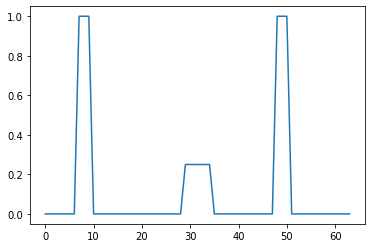

In [29]:
plt.plot(x_true)
plt.plot(xTikhI)
plt.plot(xTikhL)